In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from rdkit import Chem
from rdkit.Chem import Descriptors

from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np

In [4]:
def get_dataset(data_set_path): 
    return pd.read_csv(data_set_path, sep=',')

drugbank = get_dataset("/projects/cc/se_users/larsson_kbvs588/test/MasterThesis/dataset/curated_data/drugbank_smiles_standard.csv")
metxbiodb = get_dataset("/projects/cc/se_users/larsson_kbvs588/test/MasterThesis/dataset/curated_data/metxbiodb_smiles_standard.csv")

unique_drugbank = get_dataset("/projects/cc/se_users/larsson_kbvs588/test/MasterThesis/dataset/curated_data/drugbank_unique_parents.csv")
unique_metxbiodb = get_dataset("/projects/cc/se_users/larsson_kbvs588/test/MasterThesis/dataset/curated_data/metxbiodb_unique_parents.csv")

In [4]:
def create_pychart(data, labels): 
    colors = ['#b7ded2', '#f6a6b2', '#f7c297', '#90d2d8']
    plt.pie(data, labels=labels, colors=colors, autopct='%1.1f%%', textprops={'fontsize': 14})

def get_duplicates_from_datasets(dataset_first, dataset_second):
    equal_count = 0
    for i, row_db in dataset_first.iterrows():
        parent = row_db['parent_smiles']
        child = row_db['child_smiles']

        duplicated = dataset_second[(dataset_second["parent_smiles"] == parent) & (dataset_second["child_smiles"] == child)]

        if not duplicated.empty: 
            equal_count += 1 
            
    return equal_count

def data_source_analysis(dataset_first, dataset_first_name, dataset_second, dataset_second_name): 
    dataset_first = dataset_first[['parent_smiles', 'child_smiles']]
    dataset_second = dataset_second[['parent_smiles', 'child_smiles']]
    duplicate_count = get_duplicates_from_datasets(dataset_first, dataset_second)

    first_dataset_length = len(dataset_first) - duplicate_count
    second_dataset_length = len(dataset_second) - duplicate_count

    labels = [dataset_first_name, dataset_second_name]
    data = [first_dataset_length, second_dataset_length]
    
    if duplicate_count > 0: 
        print(f"Duplicates {duplicate_count}")
        data.append(duplicate_count)
        labels.append(f"{dataset_first_name} and {dataset_second_name}")
    
    total_dataset_length = first_dataset_length + second_dataset_length + duplicate_count
    print('Total: ', total_dataset_length)
    create_pychart(data, labels)

Duplicates 65
Total:  3364


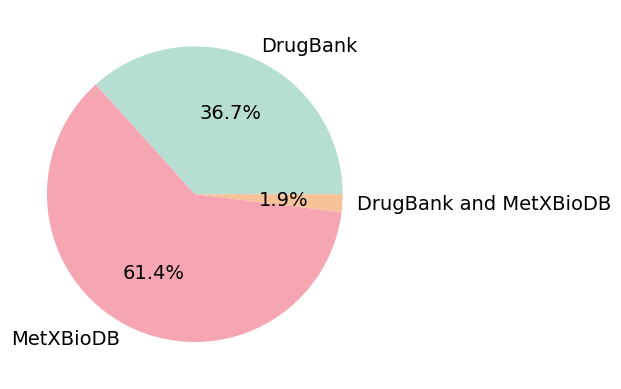

In [5]:
data_source_analysis(drugbank, 'DrugBank', metxbiodb, 'MetXBioDB')

Duplicates 25
Total:  1913


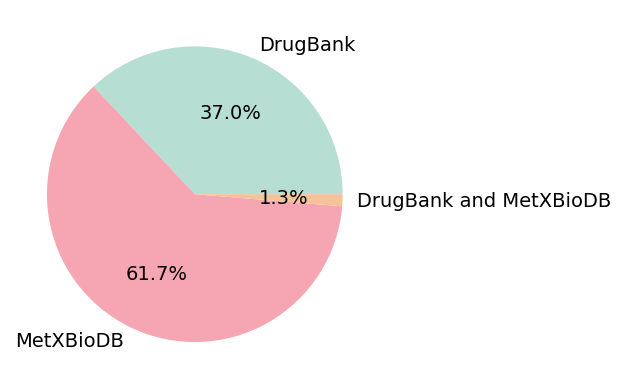

In [6]:
data_source_analysis(unique_drugbank, 'DrugBank', unique_metxbiodb, 'MetXBioDB')

In [7]:
def finger_print_similarity(dataset):
    parent_smiles = dataset['parent_smiles'].tolist()
    metabolite_smiles = dataset['child_smiles'].tolist()

    parent_mol = [Chem.MolFromSmiles(x) for x in parent_smiles]
    metabolite_mol = [Chem.MolFromSmiles(x) for x in metabolite_smiles]

    # parent_fps = [Chem.RDKFingerprint(x) for x in parent_mol]
    # metabolite_fps = [Chem.RDKFingerprint(x) for x in metabolite_mol]

    parent_fps = [AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=1024) for x in parent_mol]
    metabolite_fps = [AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=1024) for x in metabolite_mol]

    fingerprint_similarities = []
    for i in range(len(parent_smiles)):
        
        s = DataStructs.TanimotoSimilarity(parent_fps[i],metabolite_fps[i]) 
        fingerprint_similarities.append(s)

    return fingerprint_similarities  

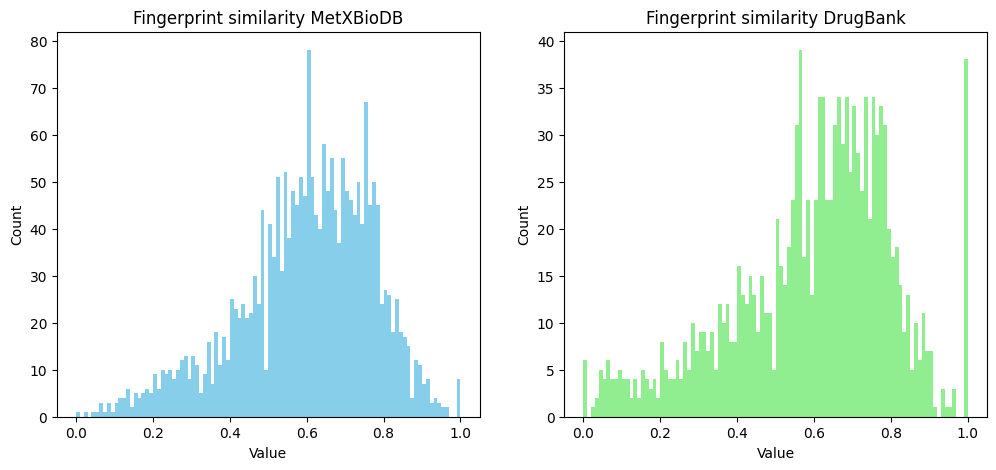

In [8]:
metxbiodb_similarities = finger_print_similarity(metxbiodb)
drugbank_similarities = finger_print_similarity(drugbank)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(metxbiodb_similarities, bins=100, color='skyblue')
ax[0].set_title('Fingerprint similarity MetXBioDB')
ax[0].set_xlabel('Value')
ax[0].set_ylabel('Count')

ax[1].hist(drugbank_similarities, bins=100, color='lightgreen')
ax[1].set_title('Fingerprint similarity DrugBank')
ax[1].set_xlabel('Value')
ax[1].set_ylabel('Count')

plt.show()

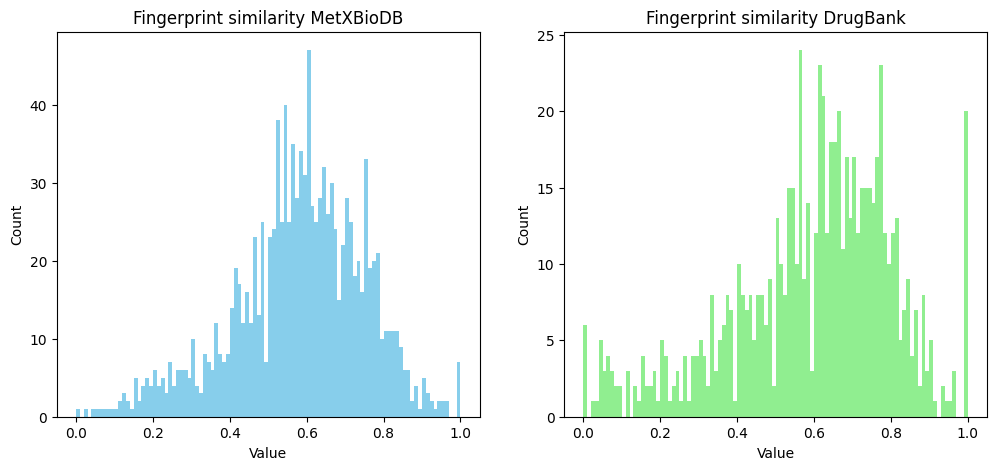

In [9]:
metxbiodb_similarities = finger_print_similarity(unique_metxbiodb)
drugbank_similarities = finger_print_similarity(unique_drugbank)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(metxbiodb_similarities, bins=100, color='skyblue')
ax[0].set_title('Fingerprint similarity MetXBioDB')
ax[0].set_xlabel('Value')
ax[0].set_ylabel('Count')

ax[1].hist(drugbank_similarities, bins=100, color='lightgreen')
ax[1].set_title('Fingerprint similarity DrugBank')
ax[1].set_xlabel('Value')
ax[1].set_ylabel('Count')

plt.show()

In [8]:
def plot_heavy_atoms(metabolite_weights, parent_weights, weights_diff):
    # Plot histograms for metabolite and parent weights side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].hist(metabolite_weights, bins=50, color='skyblue')
    axes[0].set_title('Metabolite Weights')
    axes[0].set_xlabel('Molecular Weight (Da)')
    axes[0].set_ylabel('Frequency')

    axes[1].hist(parent_weights, bins=50, color='lightgreen')
    axes[1].set_title('Parent Weights')
    axes[1].set_xlabel('Molecular Weight (Da)')
    axes[1].set_ylabel('Frequency')

    # Make y-axes equal
    histograms = [axes[0], axes[1]]
    max_ylim = max(ax.get_ylim()[1] for ax in histograms)  # Find the maximum y-limit
    for ax in histograms:
        ax.set_ylim(top=max_ylim)

    plt.tight_layout()
    plt.show()

    # Plot histogram for weight differences
    plt.figure(figsize=(6, 5))
    plt.hist(weights_diff, bins=40, color='magenta')
    plt.title('Weight Differences (Parent - Metabolite)')
    plt.xlabel('Weight Difference (Da)')
    plt.ylabel('Frequency')
    plt.show()

# def plot_heavy_atoms(children_ha, parents_ha, has_diff):
#     # Function to plot the number of heavy atoms
#     plt.figure(figsize=(10, 5))
    
#     # Plot histograms
#     plt.hist(parents_ha, bins=20, alpha=0.5, label='Parent Heavy Atoms')
#     plt.hist(children_ha, bins=20, alpha=0.5, label='Child Heavy Atoms')
    
#     plt.title('Distribution of Heavy Atoms in Molecules')
#     plt.xlabel('Number of Heavy Atoms')
#     plt.ylabel('Frequency')
#     plt.legend(loc='upper right')
    
#     plt.show()


def heavy_atoms_analysis(dataset):
    # Initialize lists to store counts of heavy atoms and differences
    children_ha, parents_ha, has_diff = [], [], []

    # Extract SMILES strings from the dataset
    parents = dataset["parent_smiles"]
    children = dataset["child_smiles"]

    for parent, child in zip(parents, children):
        # Convert SMILES to RDKit Mol objects
        parent_mol = Chem.MolFromSmiles(parent)
        child_mol = Chem.MolFromSmiles(child)
        
        # Count heavy atoms (non-hydrogen atoms) in parents and children
        parent_ha = sum(atom.GetAtomicNum() > 1 for atom in parent_mol.GetAtoms())
        child_ha = sum(atom.GetAtomicNum() > 1 for atom in child_mol.GetAtoms())

        # Append counts to corresponding lists
        parents_ha.append(parent_ha)
        children_ha.append(child_ha)

        # Calculate difference in heavy atom count and append to differences list
        ha_diff = parent_ha - child_ha
        has_diff.append(ha_diff)

    # Call the plotting function
    plot_heavy_atoms(children_ha, parents_ha, has_diff)

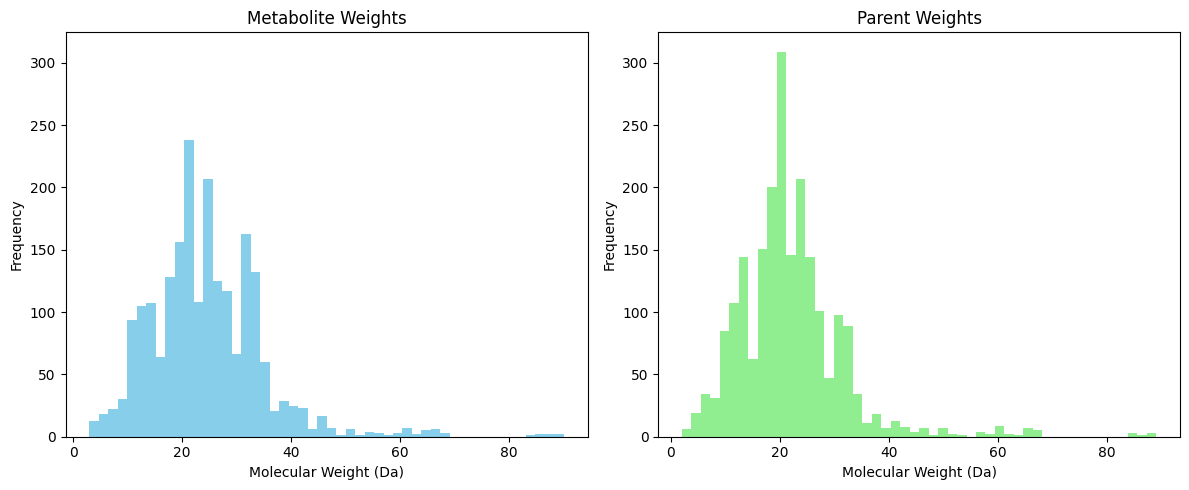

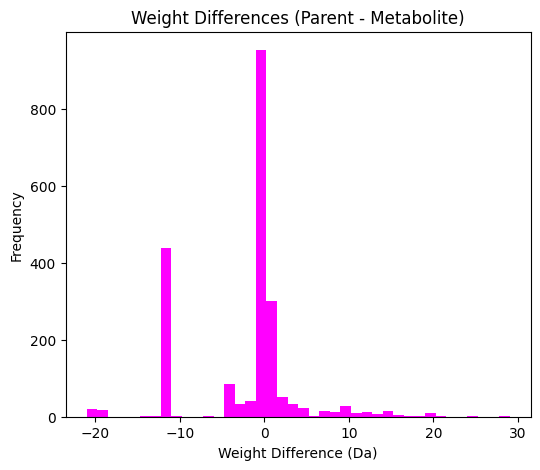

In [9]:
heavy_atoms_analysis(metxbiodb)

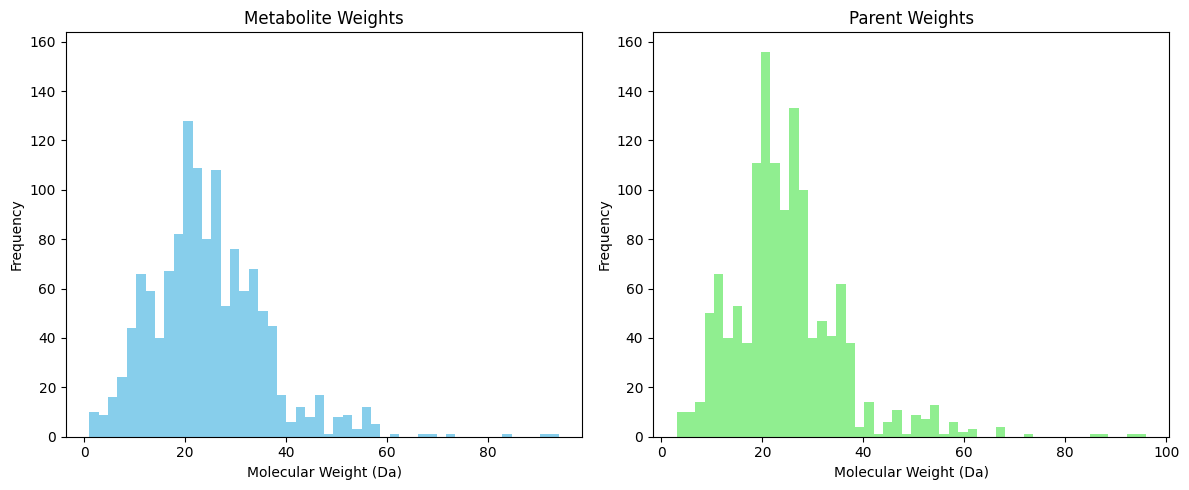

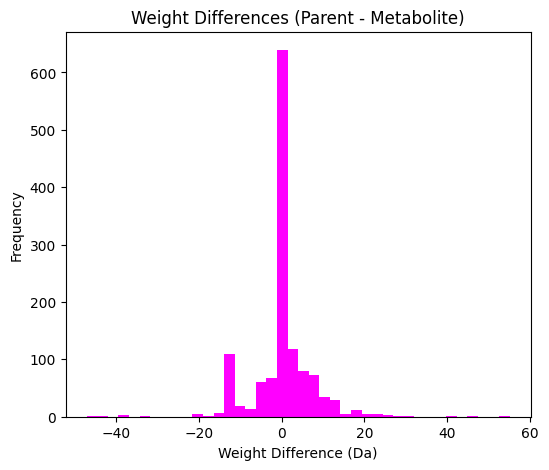

In [10]:
heavy_atoms_analysis(drugbank)